In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch 
import torchvision
from torch import nn

%pip install git+https://github.com/d2l-ai/d2l-zh@release  # installing d2l
from d2l import torch as d2l

/Users/LC/.zshenv:.:1: no such file or directory: /Users/LC/.cargo/env
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
  Cloning https://github.com/d2l-ai/d2l-zh (to revision release) to /private/var/folders/2z/wn7tz9kd6yx1bqw_m_g2cym40000gr/T/pip-req-build-ktai8hb9
  Running command git clone --filter=blob:none --quiet https://github.com/d2l-ai/d2l-zh /private/var/folders/2z/wn7tz9kd6yx1bqw_m_g2cym40000gr/T/pip-req-build-ktai8hb9
  on a case-insensitive filesystem) and only one from the same
  colliding group is in the working tree:

    'img/Marginal.svg'
    'img/marginal.svg'
    'img/Neuron.svg'
    'img/neuron.svg'
  Running command git checkout -b release --track origin/release
  Switched to a new branch 'release'
  branch 'release' set up to track 'origin/release'.
  Re

In [2]:
rgb_mean = torch.tensor([0.485, 0.456, 0.406])
rgb_std = torch.tensor([0.229, 0.224, 0.225])

# Image to Tensor
def preprocess(img, image_shape):
    if img.mode != 'RGB':
        img = img.convert('RGB')
        
    transforms = torchvision.transforms.Compose([
        torchvision.transforms.Resize(image_shape),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=rgb_mean, std=rgb_std)
    ])
    return transforms(img).unsqueeze(0)

# Tensor to Image
def postprocess(img):
    img = img[0].to(rgb_std.device)
    img = torch.clamp(img.permute(1, 2, 0) * rgb_std + rgb_mean, 0, 1)
    return torchvision.transforms.ToPILImage()(img.permute(2, 0, 1))

In [3]:
pretrained_net = torchvision.models.vgg19(pretrained=True)

style_layers, content_layers = [0, 5, 10, 19, 28], [25] # low layer -> high layer; details -> overview

net = nn.Sequential(*[pretrained_net.features[i] for i in range(max(content_layers + style_layers) + 1)])

def extract_features(X, content_layers, style_layers):
    contents = []
    styles = []
    for i in range(len(net)):
        X = net[i](X)
        if i in style_layers:
            styles.append(X)
        if i in content_layers:
            contents.append(X)
    return contents, styles

def get_contents(image_shape, device):
    content_X = preprocess(content_img, image_shape).to(device)
    contents_Y, _ = extract_features(content_X, content_layers, style_layers)
    return content_X, contents_Y

def get_styles(image_shape, device):
    style_X = preprocess(style_img, image_shape).to(device)
    _, styles_Y = extract_features(style_X, content_layers, style_layers)
    return style_X, styles_Y

/usr/local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
def content_loss(Y_hat, Y):
    return torch.square(Y_hat - Y.detach()).mean()

# check the statistical info as the style info
def gram(X):
    """
    Computes the Gram matrix of a given tensor.

    Parameters:
        X (torch.Tensor): Input tensor of shape (batch_size, num_channels, height, width).

    Returns:
        torch.Tensor: Gram matrix of shape (num_channels, num_channels), representing the style information.
    """
    num_channels, n = X.shape[1], d2l.size(X) // X.shape[1]
    X = d2l.reshape(X, (num_channels, n))
    return d2l.matmul(X, X.T) / (num_channels * n)

def style_loss(Y_hat, gram_Y):
    return torch.square(gram(Y_hat) - gram_Y.detach()).mean()

# Total Variation (TV) denoising loss function
def tv_loss(Y_hat):
    return 0.5 * (d2l.abs(Y_hat[:, :, 1:, :] - Y_hat[:, :, :-1, :]).mean() +
                  d2l.abs(Y_hat[:, :, :, 1:] - Y_hat[:, :, :, :-1]).mean())

In [5]:
content_weight, style_weight, tv_weight = 1, 1e4, 10

def compute_loss(X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram):
    contents_l = [content_loss(Y_hat, Y) * content_weight for Y_hat, Y in zip(
        contents_Y_hat, contents_Y)]
    styles_l = [style_loss(Y_hat, Y) * style_weight for Y_hat, Y in zip(
        styles_Y_hat, styles_Y_gram)]
    tv_l = tv_loss(X) * tv_weight
    # total loss
    l = sum(10 * styles_l + contents_l + [tv_l])
    return contents_l, styles_l, tv_l, l

In [6]:
# Train the X!

class SynthesizedImage(nn.Module):
    def __init__(self, img_shape, **kwargs):
        super(SynthesizedImage, self).__init__(**kwargs)
        self.weight = nn.Parameter(torch.rand(*img_shape))

    def forward(self):
        return self.weight

def get_inits(X, device, lr, styles_Y):
    gen_img = SynthesizedImage(X.shape).to(device)
    gen_img.weight.data.copy_(X.data)
    trainer = torch.optim.Adam(gen_img.parameters(), lr=lr)
    styles_Y_gram = [gram(Y) for Y in styles_Y] # pre-calculate
    return gen_img(), styles_Y_gram, trainer

In [7]:
def train(X, contents_Y, styles_Y, device, lr, num_epochs, lr_decay_epoch):
    X, styles_Y_gram, trainer = get_inits(X, device, lr, styles_Y)
    scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_decay_epoch, 0.8)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[10, num_epochs],
                            legend=['content', 'style', 'TV'],
                            ncols=2, figsize=(7, 2.5))
    for epoch in range(num_epochs):
        trainer.zero_grad()
        contents_Y_hat, styles_Y_hat = extract_features(
            X, content_layers, style_layers)
        contents_l, styles_l, tv_l, l = compute_loss(
            X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram)
        l.backward()
        trainer.step()
        scheduler.step()
        if (epoch + 1) % 10 == 0:
            animator.axes[1].imshow(postprocess(X))
            animator.add(epoch + 1, [float(sum(contents_l)),
                                     float(sum(styles_l)), float(tv_l)])
    return X

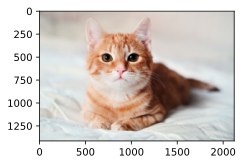

In [8]:
# Set figure size
d2l.set_figsize()

# Load and display the image
content_img = d2l.Image.open('./cat.JPG')
plt.imshow(content_img)

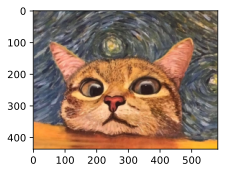

In [9]:
# Load and display the image
style_img = d2l.Image.open('./paint.JPG')
plt.imshow(style_img)

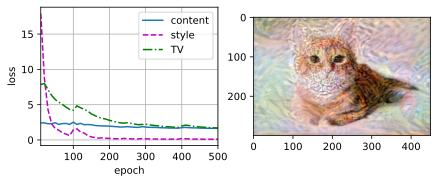

In [10]:
device, image_shape = d2l.try_gpu(), (300, 450)
net = net.to(device)
content_X, contents_Y = get_contents(image_shape, device)
style_X, styles_Y = get_styles(image_shape, device)
output = train(content_X, contents_Y, styles_Y, device, 0.3, 500, 50)

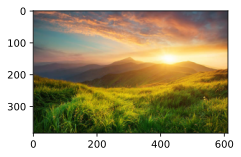

In [11]:
# Set figure size
d2l.set_figsize()

# Load and display the image
content_img = d2l.Image.open('./mountain.JPG')
plt.imshow(content_img)

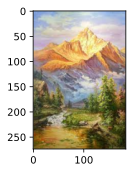

In [12]:
# Load and display the image
style_img = d2l.Image.open('./m_paint.JPG')
plt.imshow(style_img)

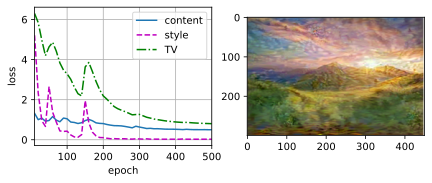

In [13]:
device, image_shape = d2l.try_gpu(), (300, 450)
net = net.to(device)
content_X, contents_Y = get_contents(image_shape, device)
style_X, styles_Y = get_styles(image_shape, device)
output = train(content_X, contents_Y, styles_Y, device, 0.3, 500, 50)